# Project

### Goal: Improve our original estimate of the log error by using clustering methodologies.

## Acquisition, Prep, and Initial Exploration

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Impute missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None, 'display.max_rows', None)

import acquire
import wrangle_zillow
import zillow_fe
import explore

from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.cluster import KMeans

In [2]:
#zillow = acquire.get_zillow(acquire.sql)
#Save file to csv to quit asking the server for this data
#zillow.to_csv('zillow.csv')
zillow = pd.read_csv('zillow.csv', index_col='id')
orig_rows = zillow.shape[0]
orig_cols = zillow.shape[1]
print (f'There are {orig_rows} rows and {orig_cols} columns in the starting dataframe.')

There are 77575 rows and 67 columns in the starting dataframe.


In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77575 entries, 1087254 to 2535331
Data columns (total 67 columns):
parcelid                        77575 non-null int64
airconditioningtypeid           25006 non-null float64
architecturalstyletypeid        206 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77575 non-null float64
bedroomcnt                      77575 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49809 non-null float64
calculatedbathnbr               76960 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6035 non-null float64
calculatedfinishedsquarefeet    77375 non-null float64
finishedsquarefeet12            73920 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50            6035 non-null float64
finishedsquarefeet6  

### Issues

- Some observations are not single-use properties
    - Restrict df to only single_use 
    - Restrict df to properties with at least 1 bedroom & bathroom
- Null and missing values
    - Fill nulls with zero where appropriate
        - ['airconditioningtypeid', 'basementsqft', 'decktypeid', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'taxdelinquencyyear']
    - Fill nulls with median value where appropriate
        - ['heatingorsystemtypeid', 'numberofstories', 'unitcnt']
- Outliers
    - Restrict df to only those values within 3 std deviations of the mean (z-score)
- Zip codes are not correct
    - Ravinder's impute function adds a new column with correct zipcode and the median income for that zipcode
- Fips column is meaningless without county names
    - Add column for county
- Multiple columns we won't use
    - drop columns
- column types are wrong
    - change column types

In [4]:
zillow = wrangle_zillow.wrangle_zillow()
# Save file to csv
zillow.to_csv('zillow_reduced.csv')

In [5]:
new_rows = zillow.shape[0]
new_cols = zillow.shape[1]
print (f'There were {orig_rows} rows and {orig_cols} columns in the starting dataframe.')
print (f'There are {new_rows} rows and {new_cols} columns in the modified dataframe.')

There were 77575 rows and 67 columns in the starting dataframe.
There are 64793 rows and 36 columns in the modified dataframe.


### Feature Engineering

1. Add new features calculated from existing
    - age: 2017 - yearbuilt
    - tax_rate: taxamount / taxvalue
    - cost_structure_sf: taxvalue / squarefeet
    - is_extra: how many extra features property has
    
    
2. One hot encode county columns

In [6]:
zillow = zillow_fe.calculated_features(zillow)

3. Bin features into 6 bins
    - sf_bin
    - age_bin
    - tax_bin

In [7]:
zillow = zillow_fe.bin_features(zillow)

4. Cluster features
    - Combine buildingquality, roomcnt & is_extra into 6 clusters
    - Combine lotsize, landtaxvalue & zipcode into 6 clusters

In [8]:
zillow = zillow_fe.cluster_features(zillow, 6)

5. Drop unnecessary columns

In [9]:
zillow = zillow_fe.drop_unnecessary_features(zillow)
# Binning created NaNs, drop them
zillow = zillow.dropna()

In [10]:
new_rows = zillow.shape[0]
new_cols = zillow.shape[1]
print (f'There were {orig_rows} rows and {orig_cols} columns in the starting dataframe.')
print (f'There are {new_rows} rows and {new_cols} columns in the modified dataframe.')

There were 77575 rows and 67 columns in the starting dataframe.
There are 64754 rows and 51 columns in the modified dataframe.


In [11]:
# added code to fix the median_income error issue:
zillow = zillow.dropna()
zillow['median_income'] = zillow.median_income.str.strip()
zillow['median_income'] = zillow.median_income.str.replace(',', '').astype(float)

In [12]:
# Save zillow to csv for use in modeling
zillow.to_csv('zillow_fe.csv')

## Explore

### Feature Distributions

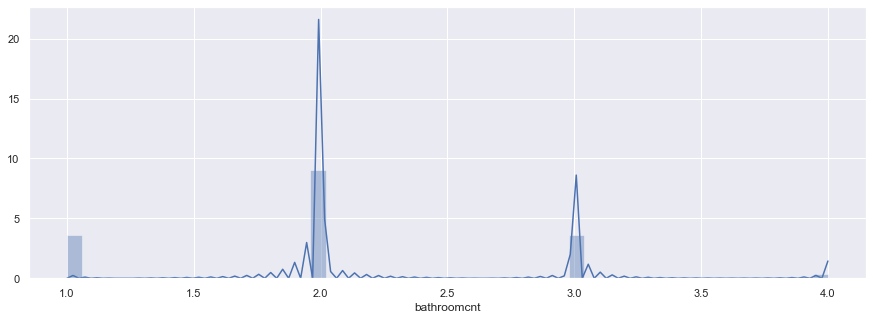

In [13]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.bathroomcnt)

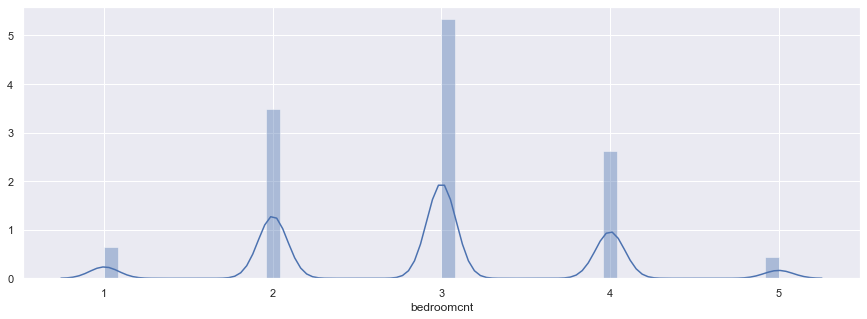

In [14]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.bedroomcnt)

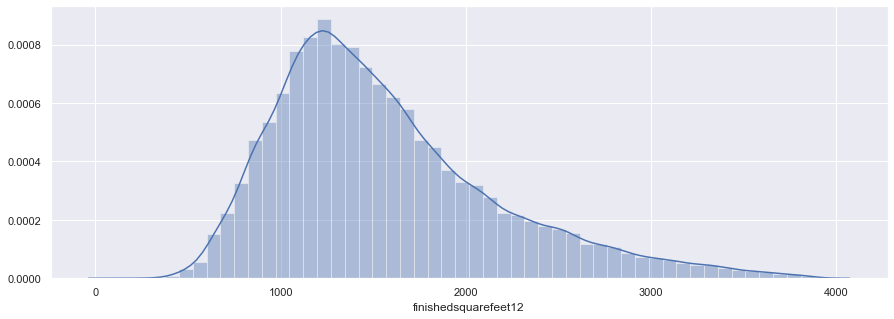

In [15]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.finishedsquarefeet12)

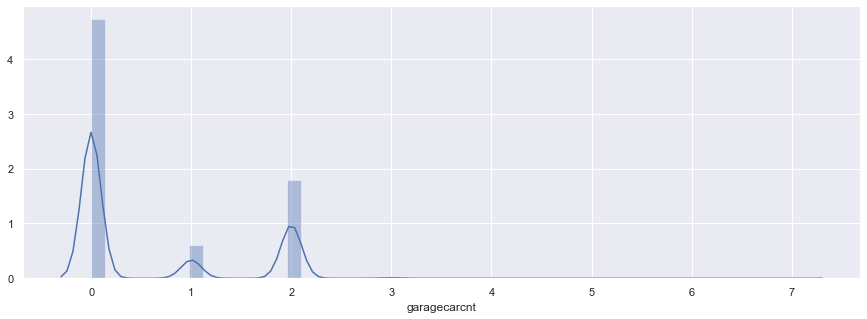

In [16]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.garagecarcnt)

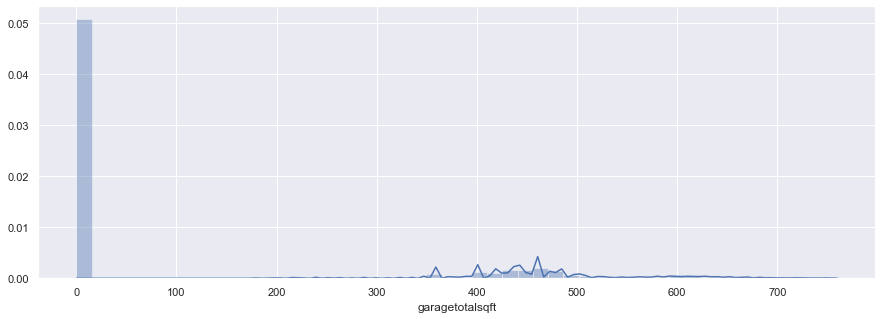

In [17]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.garagetotalsqft)

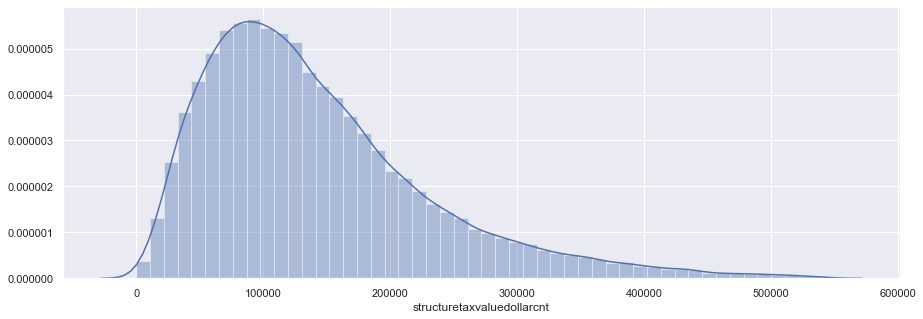

In [18]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.structuretaxvaluedollarcnt)

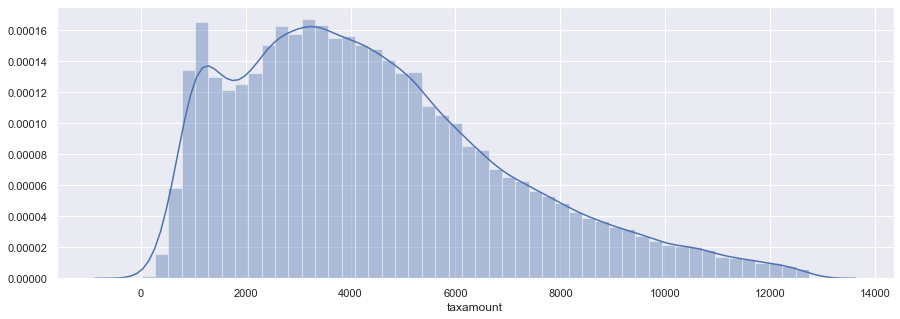

In [19]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.taxamount)

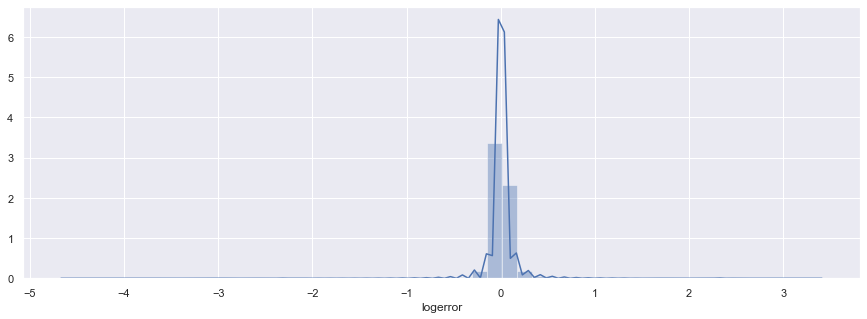

In [20]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.logerror)

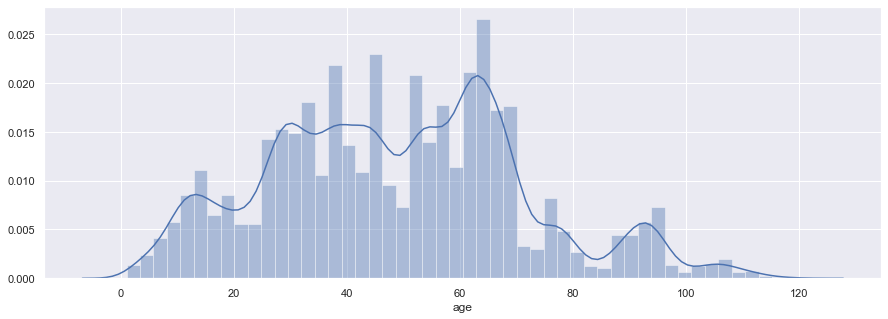

In [21]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.age)

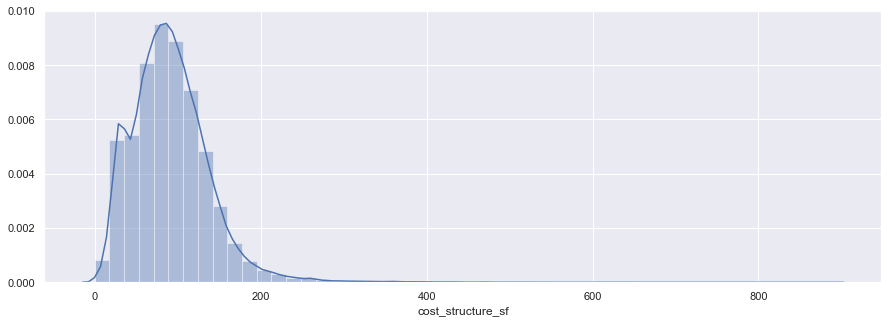

In [22]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.cost_structure_sf)

### Extra Features

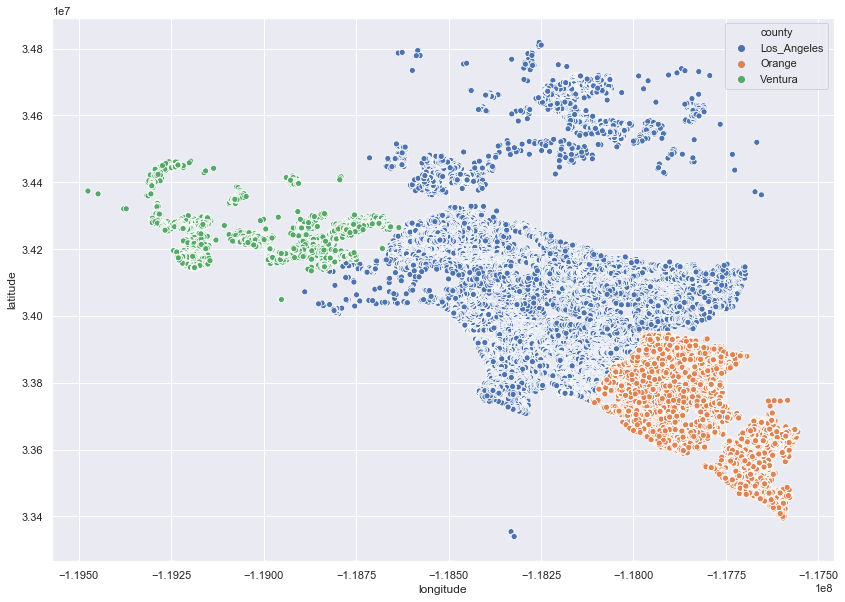

In [23]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.county, data=zillow)

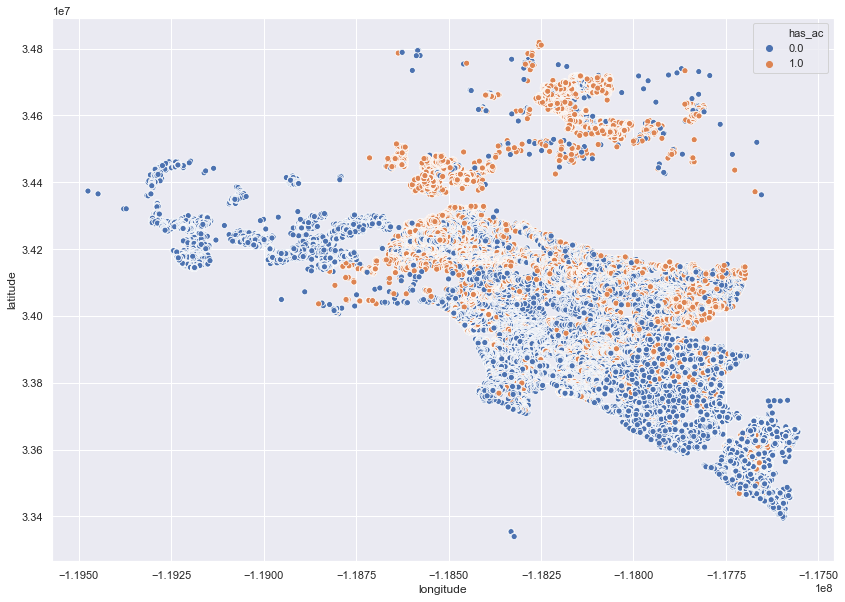

In [24]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_ac).astype('float'), data=zillow)

> Air conditioning systems are not as common as expected. They seem more common in LA County- Ventura and Orange counties practically have none.

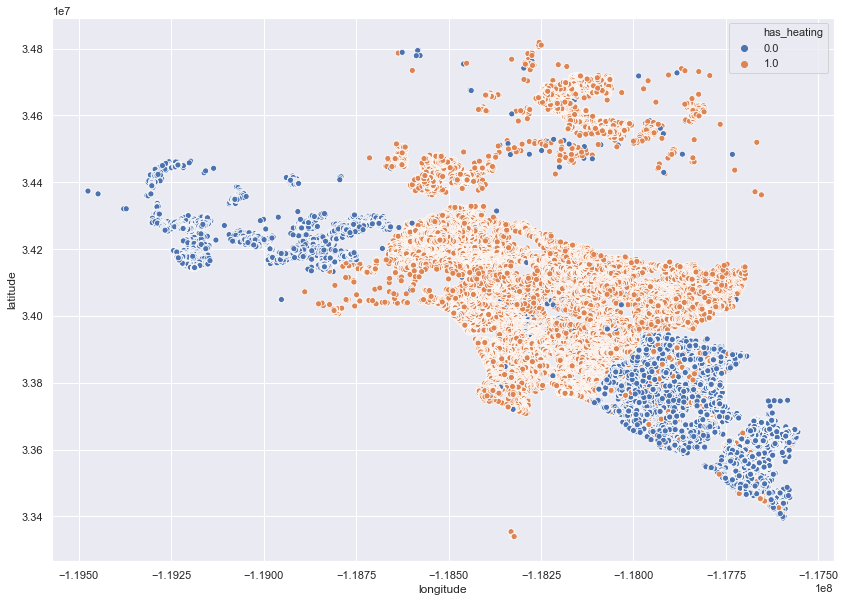

In [25]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_heating).astype('float'), data=zillow)

> Heating systems are restricted to the central area. Again, they seem more common in LA County.

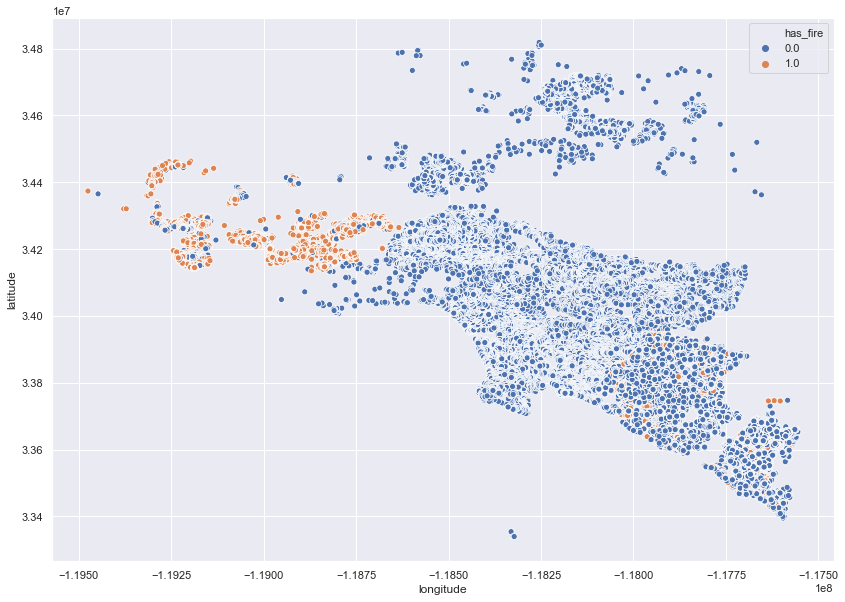

In [26]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_fire).astype('float'), data=zillow)

> Interestingly, only Ventura County has fireplaces, except for a few in Orange County.

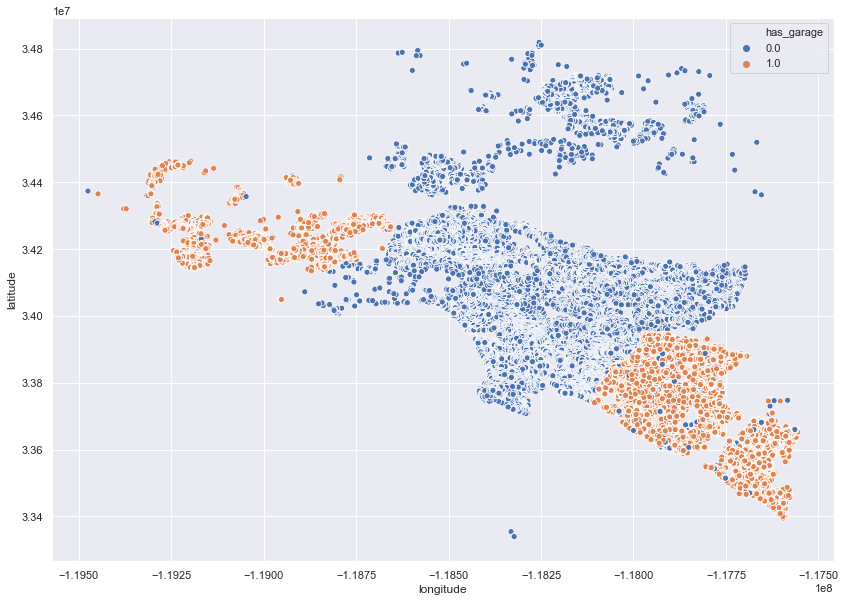

In [27]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_garage).astype('float'), data=zillow)

> LA County doesn't like garages! It almost seems like a mistake.

### Calculated Features

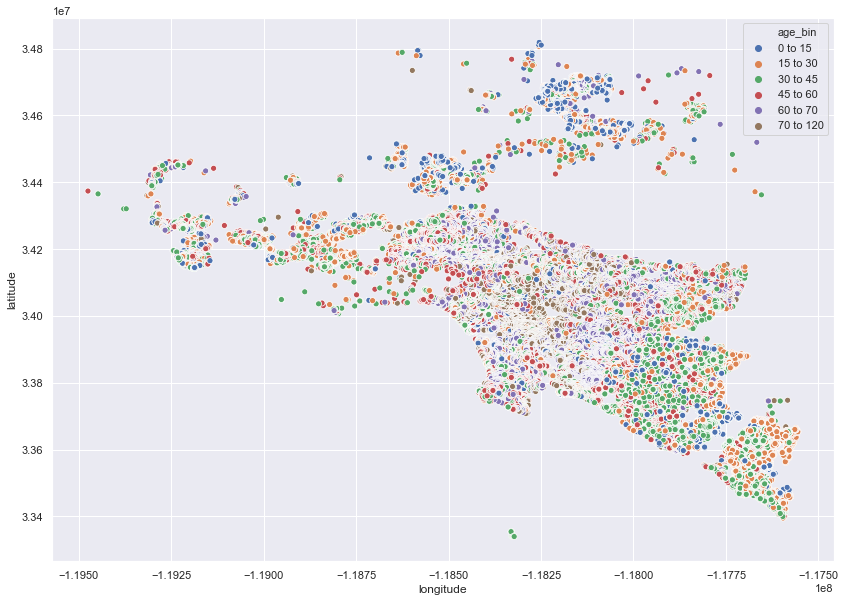

In [28]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.age_bin, data=zillow)

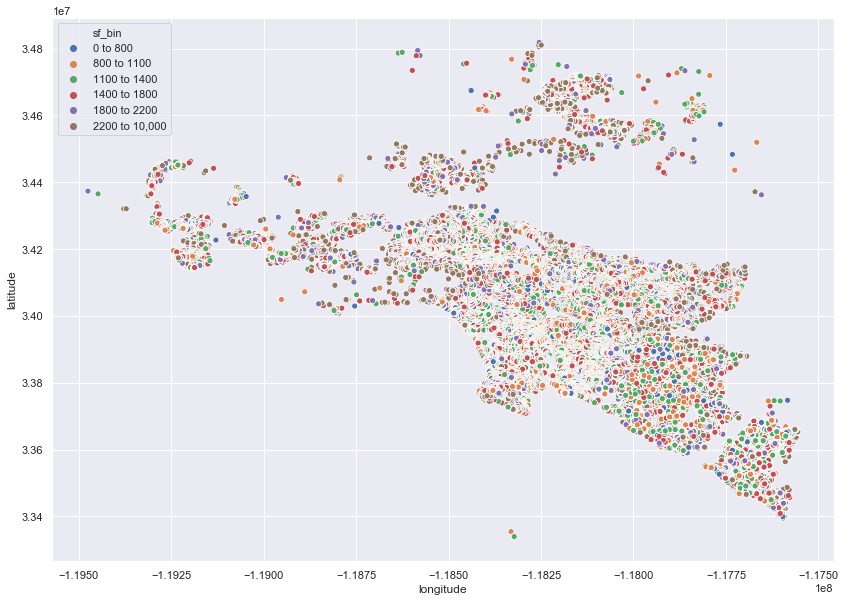

In [29]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.sf_bin, data=zillow)

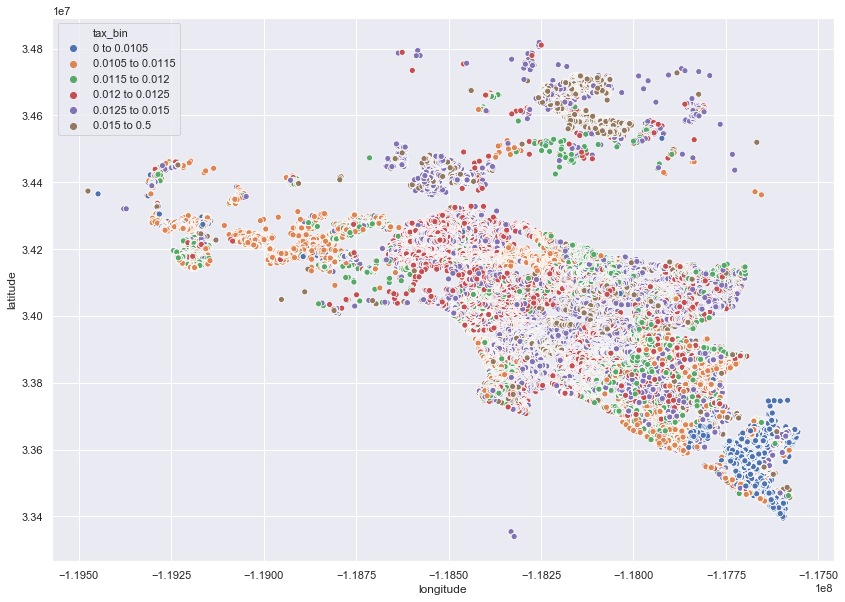

In [30]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.tax_bin, data=zillow)

### Clustered Features

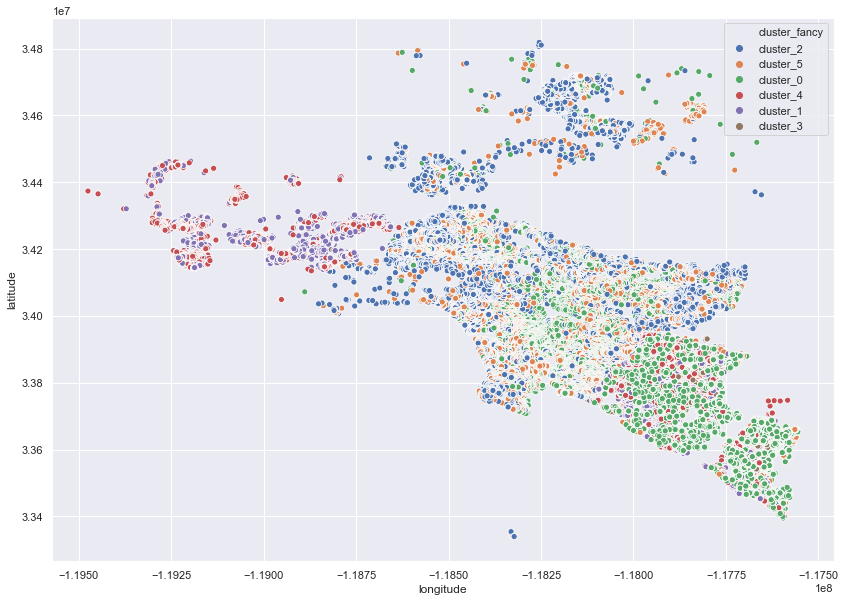

In [31]:
# Clustered on 'buildingqualitytypeid', 'roomcnt', 'is_extra'
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.cluster_fancy, data=zillow)

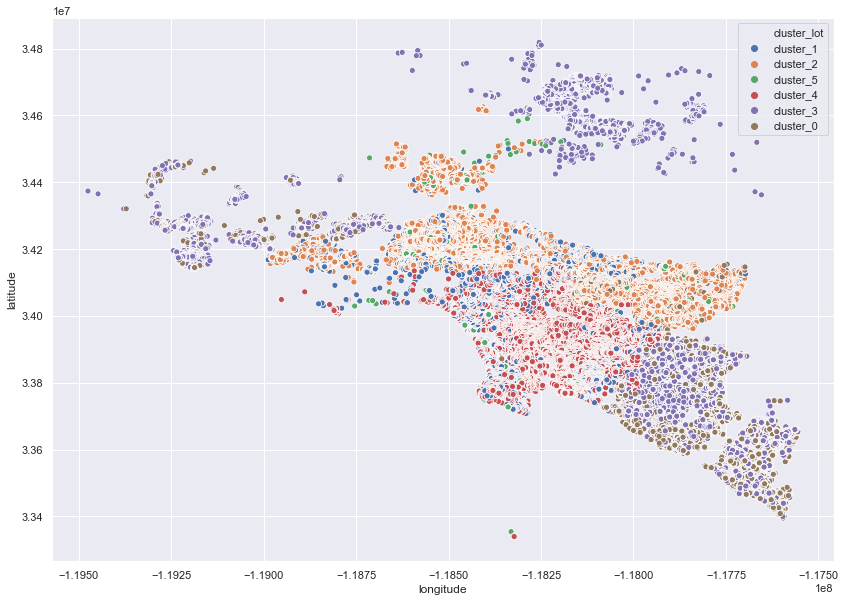

In [32]:
# Clustered on 'lotsizesquarefeet', 'landtaxvaluedollarcnt', 'new_zip'
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.cluster_lot, data=zillow)

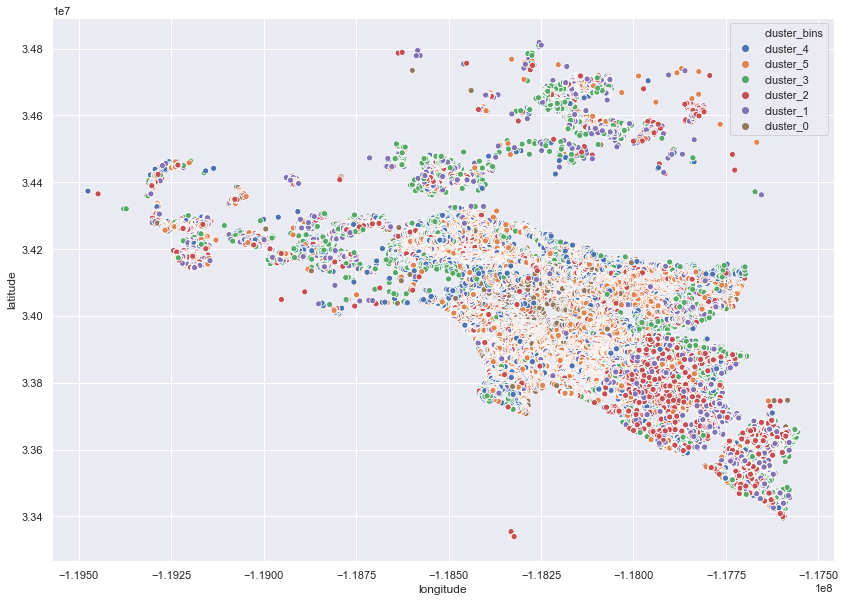

In [33]:
# Clustered on 'finishedsquarefeet12', 'age', 'tax_rate'
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.cluster_bins, data=zillow)

### Log Error Exploration

In [34]:
train, test = train_test_split(zillow, train_size = .80, random_state = 539)
train, validate = train_test_split(train, train_size = .80, random_state = 539)    

In [35]:
X = train[['logerror']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 5)

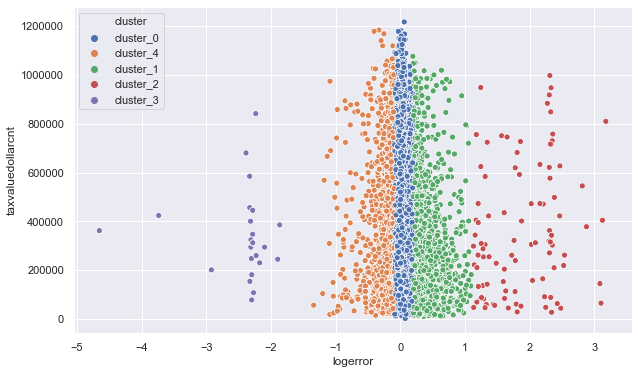

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt', data = train, hue = 'cluster')

### It seems that log error has much wider distribution at lower values houses
***

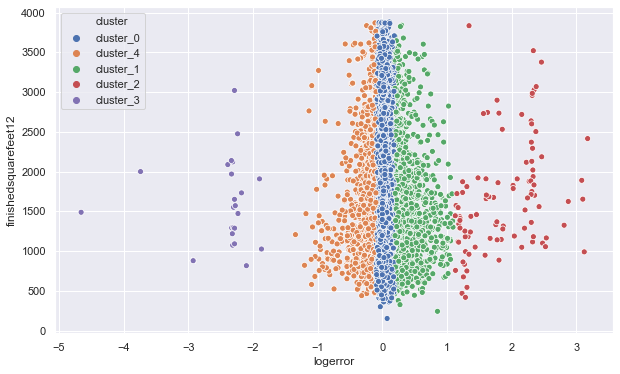

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'finishedsquarefeet12', data = train, hue = 'cluster')

###  logerror has much higher spread smaller sized houses
***

### clustering by independent variables

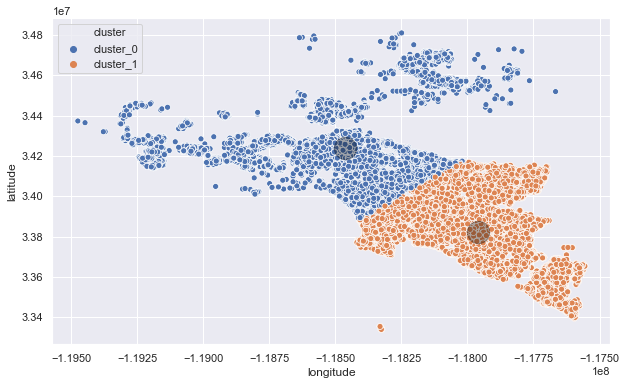

In [38]:
X = train[['latitude', 'longitude', 'logerror']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 2)
explore.scatter_plot('longitude', 'latitude',train,kmeans, X_scaled, scaler)

In [39]:
#Lets look at logerror means for two clusters
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
#print(train[train.cluster == 'cluster_2'].logerror.mean())

0.009050356730982454
0.018680587140019352


##### Lets do a t-test to see if these two clusters are statistically different from each other
$H_0$: The two clusters have similar mean logerror\
$H_a$: The two clusters have different mean logerror



In [40]:
# Lets do a t-test to see if these two clusters are statistically different from each other
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-5.915609275583644, pvalue=3.3323872681576975e-09)

##### Since the p value is almost zero, we reject the null hypothesis. This tells us that the two clusters have statistically significant difference in mean logerros



### Now we will explore finished square feet and logmean error

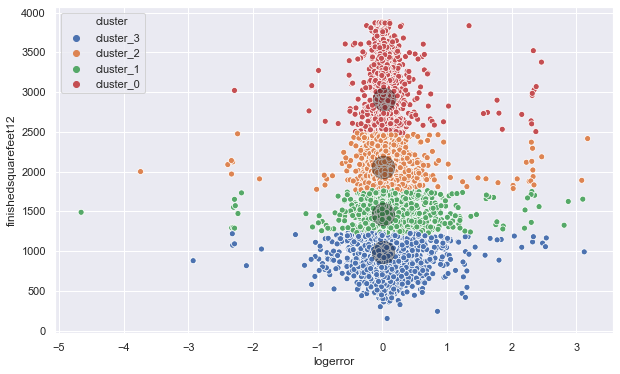

In [41]:
X = train[['finishedsquarefeet12','logerror']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 4)
explore.scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)

In [42]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())
print(train[train.cluster == 'cluster_3'].logerror.mean())

0.025899278039350233
0.014467718142534803
0.017588635069487654
0.009387924355791695


##### Lets do a ANOVA test to see if these  clusters are statistically different from each other
$H_0$: The clusters have similar mean logerror\
$H_a$: The clusters have different mean logerror



In [43]:
#We will do ANOVA (F-test) to compare the four groups
stats.f_oneway(train[train.cluster == 'cluster_0'].logerror, train[train.cluster == 'cluster_0'].logerror,\
               train[train.cluster == 'cluster_2'].logerror, train[train.cluster == 'cluster_3'].logerror)

F_onewayResult(statistic=15.665057097676014, pvalue=3.5462581342168724e-10)

##### Since the p value is almost zero, we reject the null hypothesis. This tells us that the  clusters have statistically significant difference in mean logerros
***

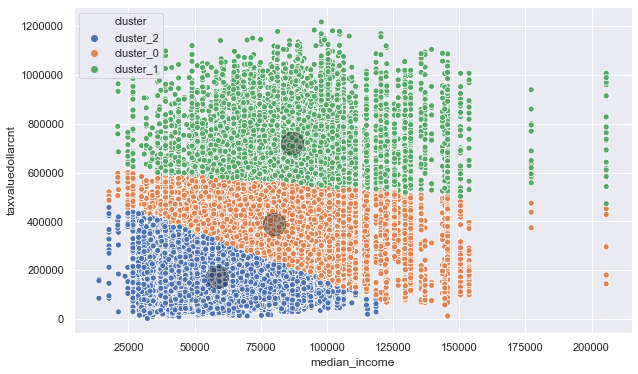

In [44]:
X = train[['taxvaluedollarcnt', 'median_income']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 3)
explore.scatter_plot('median_income','taxvaluedollarcnt',train,kmeans, X_scaled, scaler)

In [45]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())

0.009367737874235692
0.014440789095479124
0.019216182329167577


##### Lets do a ANOVA test to see if these  clusters are statistically different from each other
$H_0$: The clusters have similar mean logerror\
$H_a$: The clusters have different mean logerror

In [46]:
#We will do ANOVA (F-test) to compare the three groups
stats.f_oneway(train[train.cluster == 'cluster_0'].logerror, train[train.cluster == 'cluster_0'].logerror,\
               train[train.cluster == 'cluster_2'].logerror)

F_onewayResult(statistic=21.555940547033973, pvalue=4.389136854260098e-10)

##### Since the p value is much higher than 0.05, we fail to reject the null hypothesis. 
***

#### Next we evaluate value_income (home value/median_income of zip code)  vs logerror

(-1.5, 1.5)

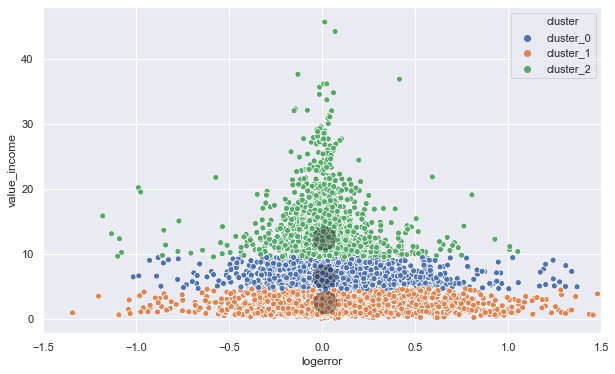

In [47]:
train['value_income'] = train.taxvaluedollarcnt/train.median_income
X = train[[ 'logerror','value_income']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 3)
explore.scatter_plot('logerror','value_income',train,kmeans, X_scaled, scaler)
plt.xlim(-1.5,1.5)

In [48]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())

0.012408247316435035
0.016606193777095962
0.012101600474479706


##### Lets do a ANOVA test to see if these  clusters are statistically different from each other
$H_0$: The clusters have similar mean logerror\
$H_a$: The clusters have different mean logerror

In [49]:
stats.f_oneway(train[train.cluster == 'cluster_0'].logerror, train[train.cluster == 'cluster_0'].logerror,\
               train[train.cluster == 'cluster_2'].logerror)

F_onewayResult(statistic=0.00728030405956998, pvalue=0.9927461345452323)

##### Since the p value is much higher than 0.05, we fail to reject the null hypothesis. 
***

#### Next we look at age vs logerror

(-1.5, 1.5)

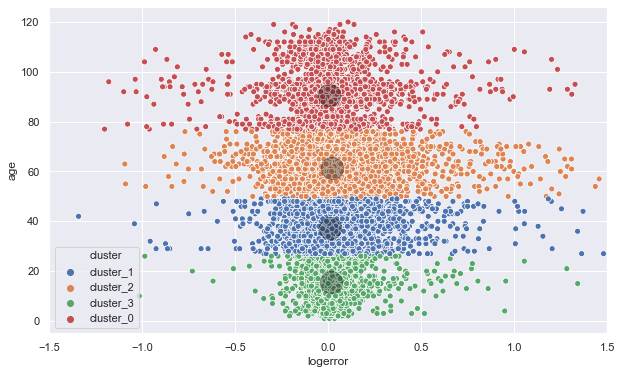

In [50]:
X = train[['age', 'logerror']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 4)
explore.scatter_plot('logerror','age',train,kmeans, X_scaled, scaler)
plt.xlim(-1.5,1.5)

In [51]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())
print(train[train.cluster == 'cluster_3'].logerror.mean())

0.006528950270188918
0.010927585353964195
0.020072177322924125
0.013998083181588968


##### Lets do a ANOVA test to see if these  clusters are statistically different from each other
$H_0$: The clusters have similar mean logerror\
$H_a$: The clusters have different mean logerror

In [52]:
stats.f_oneway(train[train.cluster == 'cluster_0'].logerror, train[train.cluster == 'cluster_0'].logerror,\
               train[train.cluster == 'cluster_2'].logerror,train[train.cluster == 'cluster_3'].logerror)

F_onewayResult(statistic=11.43885679409705, pvalue=1.7138140899119276e-07)

##### Since the p value is almost zero, we reject the null hypothesis. This means these age clusters have singificantly different logerror mean  
***

In [53]:
train['living_area'] = train.lotsizesquarefeet/train.finishedsquarefeet12

<Figure size 720x432 with 0 Axes>

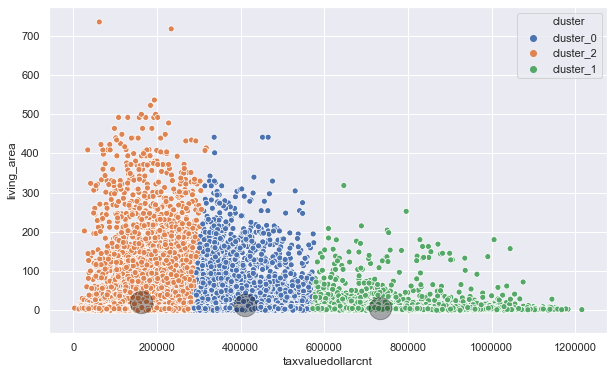

In [54]:
X = train[['living_area', 'taxvaluedollarcnt']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 3)
plt.figure(figsize=(10, 6))
explore.scatter_plot('taxvaluedollarcnt','living_area',train,kmeans, X_scaled, scaler)


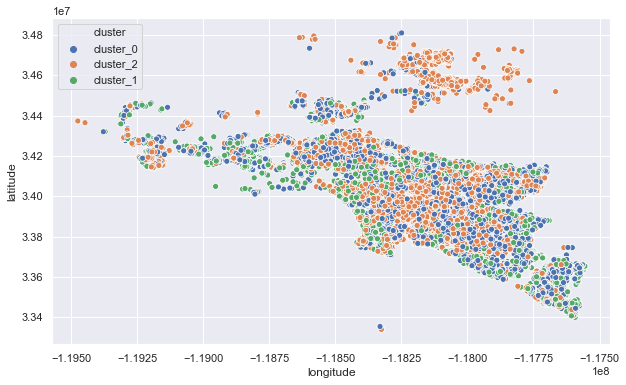

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y = 'latitude', x = 'longitude', data = train, hue = 'cluster')

In [56]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())

0.010659153783765198
0.015234837754908567
0.017646189972198384


##### Lets do a ANOVA test to see if these  clusters are statistically different from each other
$H_0$: The clusters have similar mean logerror\
$H_a$: The clusters have different mean logerror

In [57]:
stats.f_oneway(train[train.cluster == 'cluster_0'].logerror, train[train.cluster == 'cluster_0'].logerror,\
               train[train.cluster == 'cluster_2'].logerror)

F_onewayResult(statistic=11.384737441419105, pvalue=1.1396586452835037e-05)

##### Since the p value is almost zero, we reject the null hypothesis. This means these clusters have singificantly different logerror mean  
***